# Performances analysis

Import base stuff and setup pool

In [1]:
import numpy as np
import pickle
import pyarraypool
import time
import tempfile
import pandas as pd
from uuid import uuid1


In [2]:
pyarraypool.configure_global_pool(
    link_path=f"{tempfile.gettempdir()}/lab_{uuid1()}.seg",
)

pyarraypool.start_pool()


Run perf tests

In [3]:
test_count = 1000
# sizes = 10, 50, 100, 500, 1000, 5000, 10_000, 50_000, 100_000, 500_000
sizes = list(range(10, 100_000, 100))

durations = np.zeros((len(sizes), test_count, 2))

for i, size in enumerate(sizes):
    # print("Benchmarking for size", size)

    arr = np.random.random(size)
    shmarr = pyarraypool.make_transferable(arr, transfer_required=False)

    for j in range(test_count):
        # Benchmark standard array transfer
        t_start = time.perf_counter()
        out = pickle.loads(pickle.dumps(arr, protocol=pickle.HIGHEST_PROTOCOL))
        t_end = time.perf_counter()
        durations[i, j, 0] = t_end - t_start

        # Benchmark shm array transfer
        t_start = time.perf_counter()
        shmout = pickle.loads(pickle.dumps(shmarr, protocol=pickle.HIGHEST_PROTOCOL))
        t_end = time.perf_counter()
        durations[i, j, 1] = t_end - t_start

        assert (out == shmout).all()

durations = durations.mean(axis=1) * 1_000_000
durations_df = pd.DataFrame(durations, index=sizes, columns=["Standard array (us)", "SHM array (us)"])
durations_df

,Standard array (us),SHM array (us)
10,15.7291,22.9883
110,15.3621,20.3033
210,14.5062,18.8306
310,14.4715,18.2574
410,14.7079,18.4848
...,...,...
99510,133.6545,25.7451
99610,128.4725,27.8147
99710,139.1311,28.0643
99810,165.0800,50.8805


<AxesSubplot:>

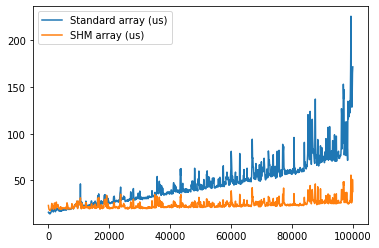

In [4]:
durations_df.plot()